2025-11-06 00:35:53.919006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 30000 samples, each with 51 frames and 3 features


I0000 00:00:1762407438.614003 1581261 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:8b:00.0, compute capability: 8.0
/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25


2025-11-06 00:37:21.711023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5079 - loss: 1.3358 - val_accuracy: 0.7183 - val_loss: 0.7996
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7473 - loss: 0.7410 - val_accuracy: 0.7769 - val_loss: 0.6111
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7957 - loss: 0.6032 - val_accuracy: 0.8200 - val_loss: 0.5163
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8264 - loss: 0.5122 - val_accuracy: 0.8671 - val_loss: 0.3709
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8462 - loss: 0.4582 - val_accuracy: 0.8679 - val_loss: 0.3822
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8656 - loss: 0.4066 - val_accuracy: 0.8481 - val_loss: 0.4371
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8778 - loss: 0.3708 - val_accuracy: 0.8948 - val_loss: 0.3217
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8873 - loss: 0.3370 - val_accuracy: 0.91

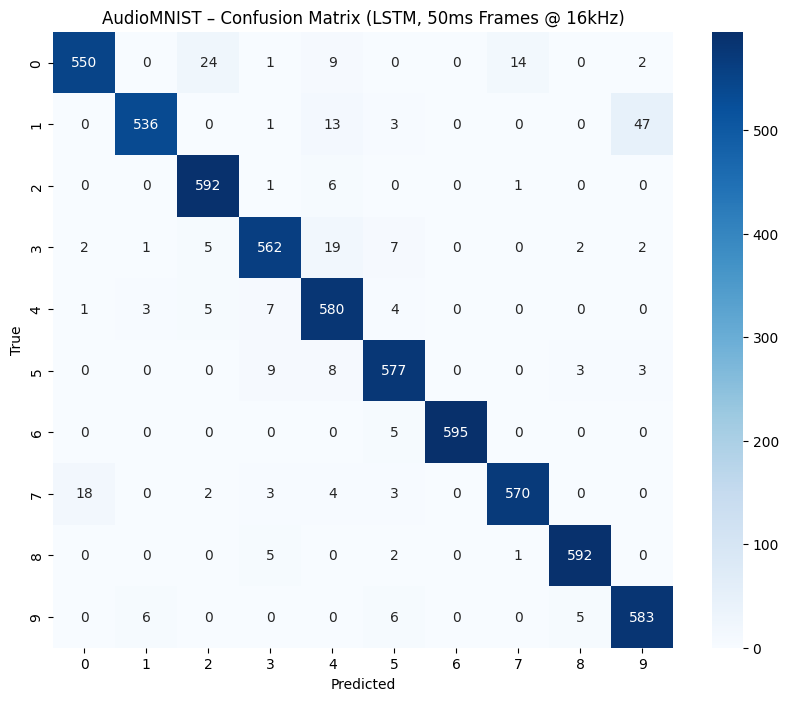


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       600
           1       0.98      0.89      0.94       600
           2       0.94      0.99      0.96       600
           3       0.95      0.94      0.95       600
           4       0.91      0.97      0.94       600
           5       0.95      0.96      0.96       600
           6       1.00      0.99      1.00       600
           7       0.97      0.95      0.96       600
           8       0.98      0.99      0.99       600
           9       0.92      0.97      0.94       600

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



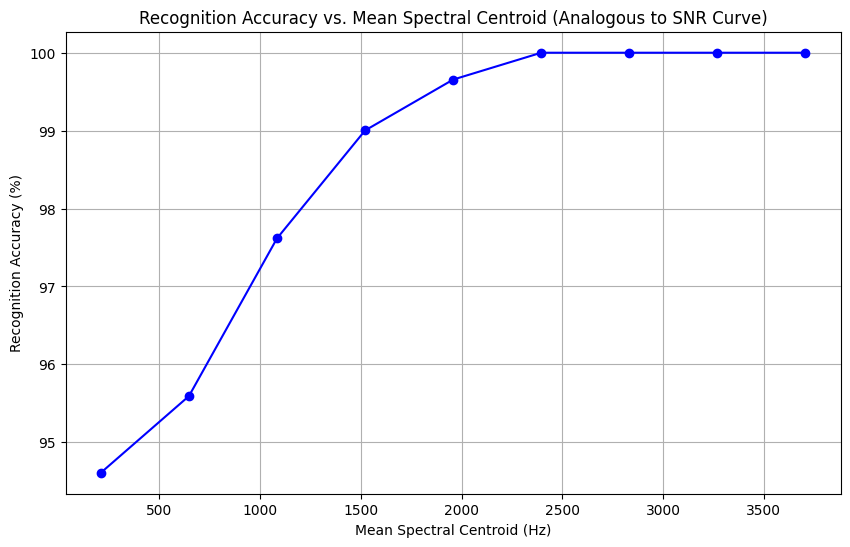

In [1]:
# Jacob M. Ramey
# AudioMNIST LSTM with Framed Raw Waveform Features
# 50ms frames @ 16kHz sampling (tunable)

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# --------------------------------------------------------------------------
# Tunable parameters
# --------------------------------------------------------------------------
SAMPLE_RATE = 16000     # Hz
FRAME_LEN_MS = 50        # frame length in milliseconds
HOP_LEN_MS = 20          # hop (overlap) in milliseconds
MAX_LEN_SEC = 1          # clip/pad to 3s
EPOCHS = 25
BATCH_SIZE = 32

# Derived values
FRAME_LEN = int(SAMPLE_RATE * FRAME_LEN_MS / 1000)
HOP_LEN = int(SAMPLE_RATE * HOP_LEN_MS / 1000)
TARGET_SAMPLES = int(SAMPLE_RATE * MAX_LEN_SEC)

# --------------------------------------------------------------------------
# Load AudioMNIST dataset
# --------------------------------------------------------------------------
import kagglehub
base_path = kagglehub.dataset_download("sripaadsrinivasan/audio-mnist")
audio_dir = os.path.join(base_path, "data")

X_frames, y_labels = [], []
centroid_means, rms_means, zcr_means = [], [], []

for root, _, files in os.walk(audio_dir):
    for f in files:
        if not f.endswith(".wav"):
            continue
        label = f.split("_")[0]
        filepath = os.path.join(root, f)
        y, _ = librosa.load(filepath, sr=SAMPLE_RATE)

        # Pad or trim
        if len(y) > TARGET_SAMPLES:
            y = y[:TARGET_SAMPLES]
        else:
            y = np.pad(y, (0, TARGET_SAMPLES - len(y)))

        # Frame-level features (shape: frames × features)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LEN, hop_length=HOP_LEN)[0]
        centroid = librosa.feature.spectral_centroid(y=y, sr=SAMPLE_RATE,
                                                     n_fft=FRAME_LEN, hop_length=HOP_LEN)[0]
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LEN, hop_length=HOP_LEN)[0]

        # Stack into [frames, 3] tensor
        frame_features = np.vstack([rms, centroid, zcr]).T
        X_frames.append(frame_features)
        y_labels.append(label)

        centroid_means.append(np.mean(centroid))
        rms_means.append(np.mean(rms))
        zcr_means.append(np.mean(zcr))

# Pad all sequences to equal length (max frame count)
max_frames = max(len(x) for x in X_frames)
for i in range(len(X_frames)):
    pad_len = max_frames - len(X_frames[i])
    X_frames[i] = np.pad(X_frames[i], ((0, pad_len), (0, 0)))

X = np.array(X_frames, dtype=np.float32)
y = np.array(y_labels)
print(f"Loaded {len(X)} samples, each with {X.shape[1]} frames and {X.shape[2]} features")

# --------------------------------------------------------------------------
# Normalize features for easier training
# --------------------------------------------------------------------------
scaler = StandardScaler()
num_samples, num_frames, num_feats = X.shape
X_2d = X.reshape(-1, num_feats)
X_scaled = scaler.fit_transform(X_2d).reshape(num_samples, num_frames, num_feats)

# --------------------------------------------------------------------------
# Encode labels and split
# --------------------------------------------------------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# --------------------------------------------------------------------------
# Build LSTM model
# --------------------------------------------------------------------------
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(le.classes_)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=input_shape),
    Dropout(0.3),
    LSTM(32),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, verbose=1)

# --------------------------------------------------------------------------
# Evaluation
# --------------------------------------------------------------------------
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)
acc = accuracy_score(y_true, y_pred) * 100
print(f"\nOverall Test Accuracy: {acc:.2f}%")

# --------------------------------------------------------------------------
# Confusion Matrix
# --------------------------------------------------------------------------
conf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AudioMNIST – Confusion Matrix (LSTM, 50ms Frames @ 16kHz)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# --------------------------------------------------------------------------
# Accuracy vs. Spectral Centroid (analogous to SNR curve)
# --------------------------------------------------------------------------
centroid_bins = np.linspace(min(centroid_means), max(centroid_means), 10)
acc_per_centroid = []

for i in range(len(centroid_bins)-1):
    idx = np.where((np.array(centroid_means) >= centroid_bins[i]) &
                   (np.array(centroid_means) < centroid_bins[i+1]))[0]
    if len(idx) == 0:
        acc_per_centroid.append(np.nan)
        continue
    X_bin = X_scaled[idx]
    y_bin = y_cat[idx]
    y_pred_bin = np.argmax(model.predict(X_bin, verbose=0), axis=1)
    y_true_bin = np.argmax(y_bin, axis=1)
    acc_bin = accuracy_score(y_true_bin, y_pred_bin) * 100
    acc_per_centroid.append(acc_bin)

plt.figure(figsize=(10,6))
plt.plot(centroid_bins[:-1], acc_per_centroid, 'b-o')
plt.xlabel("Mean Spectral Centroid (Hz)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Recognition Accuracy vs. Mean Spectral Centroid (Analogous to SNR Curve)")
plt.grid(True)
plt.show()


Starting fine-tune training for 15 epochs (lr=0.0001)
Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9747 - loss: 0.0825 - val_accuracy: 0.9706 - val_loss: 0.0959 - learning_rate: 1.0000e-04
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9778 - loss: 0.0728 - val_accuracy: 0.9708 - val_loss: 0.0966 - learning_rate: 1.0000e-04
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9774 - loss: 0.0688 - val_accuracy: 0.9729 - val_loss: 0.0928 - learning_rate: 1.0000e-04
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9796 - loss: 0.0650 - val_accuracy: 0.9731 - val_loss: 0.0923 - learning_rate: 1.0000e-04
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9793 - loss: 0.0653 - val_accuracy: 0.9719 - val_loss: 0.0999 - learning_rate: 1.0000e-04
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9795 - loss: 0.0657 - val_accuracy: 0.9727 - val_loss: 0.0920 - learning_rate: 1.0000e-04
Epo

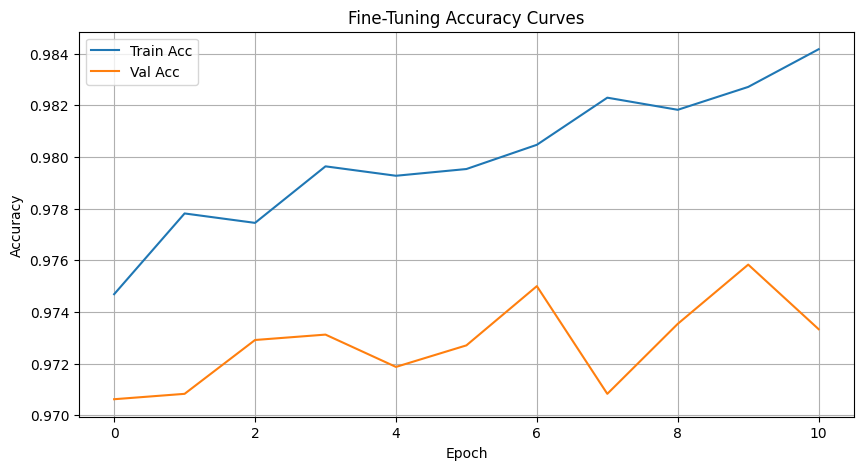

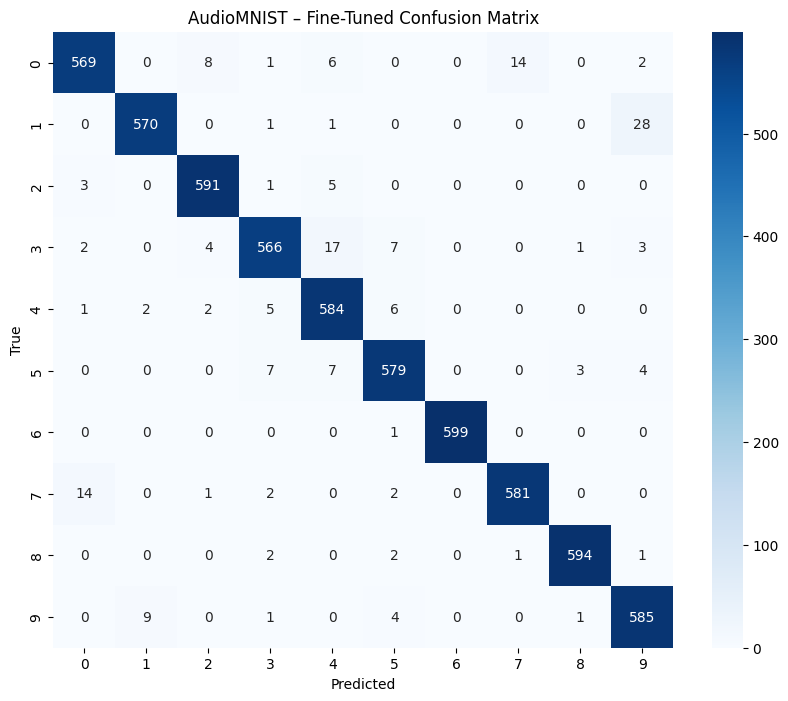


Classification Report After Fine-Tuning:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       600
           1       0.98      0.95      0.97       600
           2       0.98      0.98      0.98       600
           3       0.97      0.94      0.95       600
           4       0.94      0.97      0.96       600
           5       0.96      0.96      0.96       600
           6       1.00      1.00      1.00       600
           7       0.97      0.97      0.97       600
           8       0.99      0.99      0.99       600
           9       0.94      0.97      0.96       600

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



In [2]:
# Jacob M. Ramey
# Fine-tuning step for AudioMNIST LSTM (fixed LR handling)

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

# --------------------------------------------------------------------------
# Fine-tuning setup
# --------------------------------------------------------------------------
FINE_TUNE_EPOCHS = 15
FINE_TUNE_LR = 1e-4
UNFREEZE_LAST_N = 2   # optional, for partial layer unfreezing

# Safely recompile with a smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Optional schedulers / early stop
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

print(f"Starting fine-tune training for {FINE_TUNE_EPOCHS} epochs (lr={FINE_TUNE_LR})")

history_ft = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=FINE_TUNE_EPOCHS,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --------------------------------------------------------------------------
# Evaluate fine-tuned model
# --------------------------------------------------------------------------
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)
acc_ft = accuracy_score(y_true, y_pred) * 100
print(f"\nFine-tuned Test Accuracy: {acc_ft:.2f}%")

# --------------------------------------------------------------------------
# Plot fine-tuning curves
# --------------------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(history_ft.history['accuracy'], label='Train Acc')
plt.plot(history_ft.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Fine-Tuning Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------
# Updated Confusion Matrix
# --------------------------------------------------------------------------
conf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AudioMNIST – Fine-Tuned Confusion Matrix")
plt.show()

print("\nClassification Report After Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=le.classes_))
